### **FINAL PROJECT** - Build a neural network to predict if a patient has pneumonia or not based on X-ray chest

By:

*   Carlos Pérez
*   Sergio Rodríguez
*   Marcos Uceta


### **1) Import everything that we need**

We will do this using Analytic Zoo with Orca.

In [1]:
# Install jdk8
!apt-get install openjdk-8-jre-headless -qq > /dev/null
import os

# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [2]:
# Install latest pre-release version of Analytics Zoo
!pip install --pre --upgrade analytics-zoo[ray]

     |████████████████████████████████| 194.7 MB 62 kB/s 
     |████████████████████████████████| 114.0 MB 28 kB/s 
     |████████████████████████████████| 218.4 MB 60 kB/s 
     |████████████████████████████████| 1.3 MB 58.3 MB/s 
     |████████████████████████████████| 62 kB 851 kB/s 
     |████████████████████████████████| 65 kB 4.8 MB/s 
     |████████████████████████████████| 47.5 MB 150 kB/s 
     |████████████████████████████████| 271 kB 60.5 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 197 kB 58.3 MB/s 
     |████████████████████████████████| 82 kB 250 kB/s 
     |████████████████████████████████| 128 kB 45.7 MB/s 
     |████████████████████████████████| 173 kB 57.3 MB/s 
     |████████████████████████████████| 3.0 MB 57.1 MB/s 
     |████████████████████████████████| 202 kB 57.5 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.6-py2.py3-none-any.whl size=2188

In [13]:
# Our data is storaged in .zip format
import zipfile

# Orca functions
from bigdl.dataset import base
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext
from pathlib import Path

# Needed to transform and plot our data
import cv2
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import torch
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from keras.callbacks import ReduceLROnPlateau

In [4]:
# For image loading and pre-processing
!pip install sparkdl
!pip install tensorframes
!pip install kaggle

     |████████████████████████████████| 99 kB 6.1 MB/s 


In [5]:
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=1) # run in local mode
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, driver_memory="6g") # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.13.1-SNAPSHOT-spark_2.4.6-0.12.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.13.1-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
2022-02-10 13:15:08 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


cls.getname: com.intel.analytics.bigdl.python.api.Sample
BigDLBasePickler registering: bigdl.util.common  Sample
cls.getname: com.intel.analytics.bigdl.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.util.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.python.api.JTensor
BigDLBasePickler registering: bigdl.util.common  JTensor
cls.getname: com.intel.analytics.bigdl.python.api.JActivity
BigDLBasePickler registering: bigdl.util.common  JActivity
Successfully got a SparkContext



User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_MWAIT_HINTS=0
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_

### **2) Load the data**

Once we imported everything that we needed, we can download the data. It is in kaggle, so we need to take it from there.

In [8]:
# Making a directory named “.kaggle”
! mkdir ~/.kaggle

# Copying the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

# Allocating the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

# Downloading the desired dataset:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

# Unzipping the data:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### **3) Pre-processed the images**

To ensure a reliable model, we need to give it reliable data to build it. In this case, we need to pre-processed the images to remove those that can be unreliable.

Filtering out corrupted images in train set:

In [9]:
num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("/content/chest_xray/chest_xray/train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 175 images


Filtering out corrupted images in test set:

In [10]:
num_skipped = 0
for folder_name in ("NORMAL", "PNEUMONIA"):
    folder_path = os.path.join("/content/chest_xray/chest_xray/test", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 38 images


### **4) Visualize the data**

To do that, first we need to configure some parameters to be able to store and see it.

In [14]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [15]:
train = get_training_data('chest_xray/chest_xray/train')
test = get_training_data('chest_xray/chest_xray/test')
val = get_training_data('chest_xray/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



When we are working with this type of data, that we will use to create machine learning models, it is vital to know with what we are working. Let's see how many images are of normal cases and how much are of pneumonia cases.

In training:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


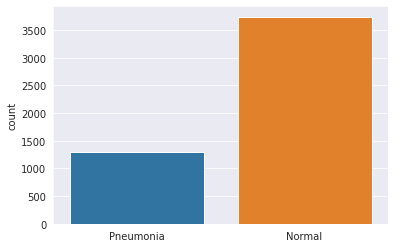

In [16]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

In validation:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


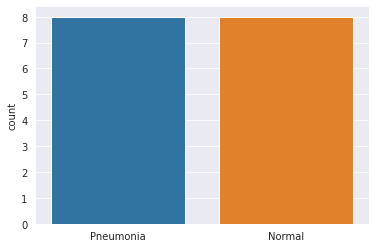

In [17]:
l = []
for i in val:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)   

In test:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


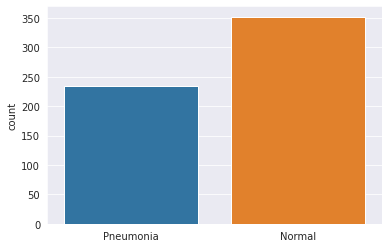

In [18]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

We have a larger number of normal samples than pneumonia samples in training set; while it is quite good distributed in validation and test set. This is important because the better distributed is our data, the better is trained our model.

Let's see how looks the normal samples and the pneumonia samples:

Text(0.5, 1.0, 'PNEUMONIA')

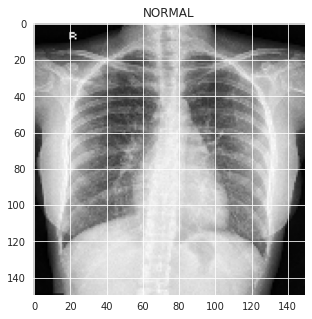

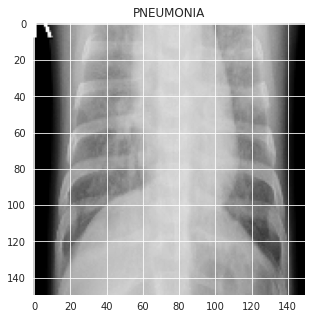

In [19]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

### **5) Create the train, validation and test sets**

We need to convert it from a directory to a set of images to give it to our model.

In [20]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_set = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 5043 images belonging to 2 classes.


In [21]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 586 images belonging to 2 classes.


In [22]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 16 images belonging to 2 classes.


### **6) Build the Convolutional Neural Network**

We are going to use keras to create our neural network.

In [23]:
cnn = tf.keras.models.Sequential()

In [24]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

cnn.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [25]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.3, min_lr=0.001)

### **7) Train our model**

In [26]:
cnn.fit(x = train_set, validation_data = val_set, batch_size= 158, epochs = 5, callbacks = [lr_reduction])

Epoch 1/5
158/158 [==============================] - 79s 489ms/step - loss: 0.4322 - accuracy: 0.8029 - val_loss: 0.4480 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/5
158/158 [==============================] - 79s 497ms/step - loss: 0.2598 - accuracy: 0.8919 - val_loss: 1.3508 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/5
158/158 [==============================] - 78s 493ms/step - loss: 0.2069 - accuracy: 0.9181 - val_loss: 1.1137 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/5
158/158 [==============================] - 77s 489ms/step - loss: 0.1901 - accuracy: 0.9294 - val_loss: 1.3482 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/5
158/158 [==============================] - 77s 488ms/step - loss: 0.1584 - accuracy: 0.9397 - val_loss: 0.9728 - val_accuracy: 0.6875 - lr: 0.0010


### **8) Predict**

In [37]:
predictions = cnn.predict(test_set, batch_size = 158, steps= 5, callbacks = [lr_reduction])

In [38]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

### **9) Evaluate our model** 

In [39]:
cnn.evaluate(test_set)

19/19 [==============================] - 9s 478ms/step - loss: 0.3738 - accuracy: 0.8788


[0.37378600239753723, 0.8788396120071411]